# Pathway Discovery and Analysis
This notebook demonstrates the complete pathway analysis pipeline using the full 400K dataset


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# First modify the pooling functions to return the list of phi arrays
def pool_batch_results_no_pc_with_list(base_path, n_batches=41):
    """Returns both pooled phi and list of individual batch phis"""
    phi_list = []
    valid_batches = 0
    
    for i in range(n_batches):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        batch_path = os.path.join(base_path, f'output_{start_idx}_{end_idx}', 'model.pt')
        
        if os.path.exists(batch_path):
            try:
                checkpoint = torch.load(batch_path, map_location='cpu')
                if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                    phi_batch = checkpoint['model_state_dict']['phi'].cpu().numpy()
                    phi_list.append(phi_batch)
                    valid_batches += 1
            except Exception as e:
                pass
    
    if phi_list:
        pooled_phi = np.mean(phi_list, axis=0)
        return pooled_phi, phi_list
    else:
        return None, []

def pool_batch_results_pc_with_list(base_path, n_batches=41):
    """Returns both pooled phi and list of individual batch phis"""
    phi_list = []
    valid_batches = 0
    
    for i in range(n_batches):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        batch_path = os.path.join(base_path, f'enrollment_model_W0.0001_batch_{start_idx}_{end_idx}.pt')
        
        if os.path.exists(batch_path):
            try:
                checkpoint = torch.load(batch_path, map_location='cpu')
                if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                    phi_batch = checkpoint['model_state_dict']['phi'].cpu().numpy()
                    phi_list.append(phi_batch)
                    valid_batches += 1
            except Exception as e:
                pass
    
    if phi_list:
        pooled_phi = np.mean(phi_list, axis=0)
        return pooled_phi, phi_list
    else:
        return None, []

# Load data
no_pc_base = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/resultshighamp/results'
phi_no_pc_mean, phi_no_pc_list = pool_batch_results_no_pc_with_list(no_pc_base, n_batches=41)

pc_base = '/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex'
phi_pc_mean, phi_pc_list = pool_batch_results_pc_with_list(pc_base, n_batches=41)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/1875671650.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(batch_path, map_loca

Phi shape: (21, 348, 52) (K=21, D=348, T=52)

Signature correlation matrix shape: (21, 21)
Diagonal (should be 1.0): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Top 15 most correlated signature pairs (from Phi):
  1. Sig 4 vs Sig 20: 0.9859
  2. Sig 15 vs Sig 20: 0.9820
  3. Sig 12 vs Sig 20: 0.9798
  4. Sig 5 vs Sig 20: 0.9766
  5. Sig 6 vs Sig 20: 0.9752
  6. Sig 11 vs Sig 20: 0.9751
  7. Sig 18 vs Sig 20: 0.9712
  8. Sig 4 vs Sig 15: 0.9694
  9. Sig 14 vs Sig 20: 0.9693
  10. Sig 4 vs Sig 12: 0.9675
  11. Sig 4 vs Sig 5: 0.9650
  12. Sig 10 vs Sig 20: 0.9650
  13. Sig 9 vs Sig 20: 0.9644
  14. Sig 12 vs Sig 15: 0.9631
  15. Sig 4 vs Sig 11: 0.9630


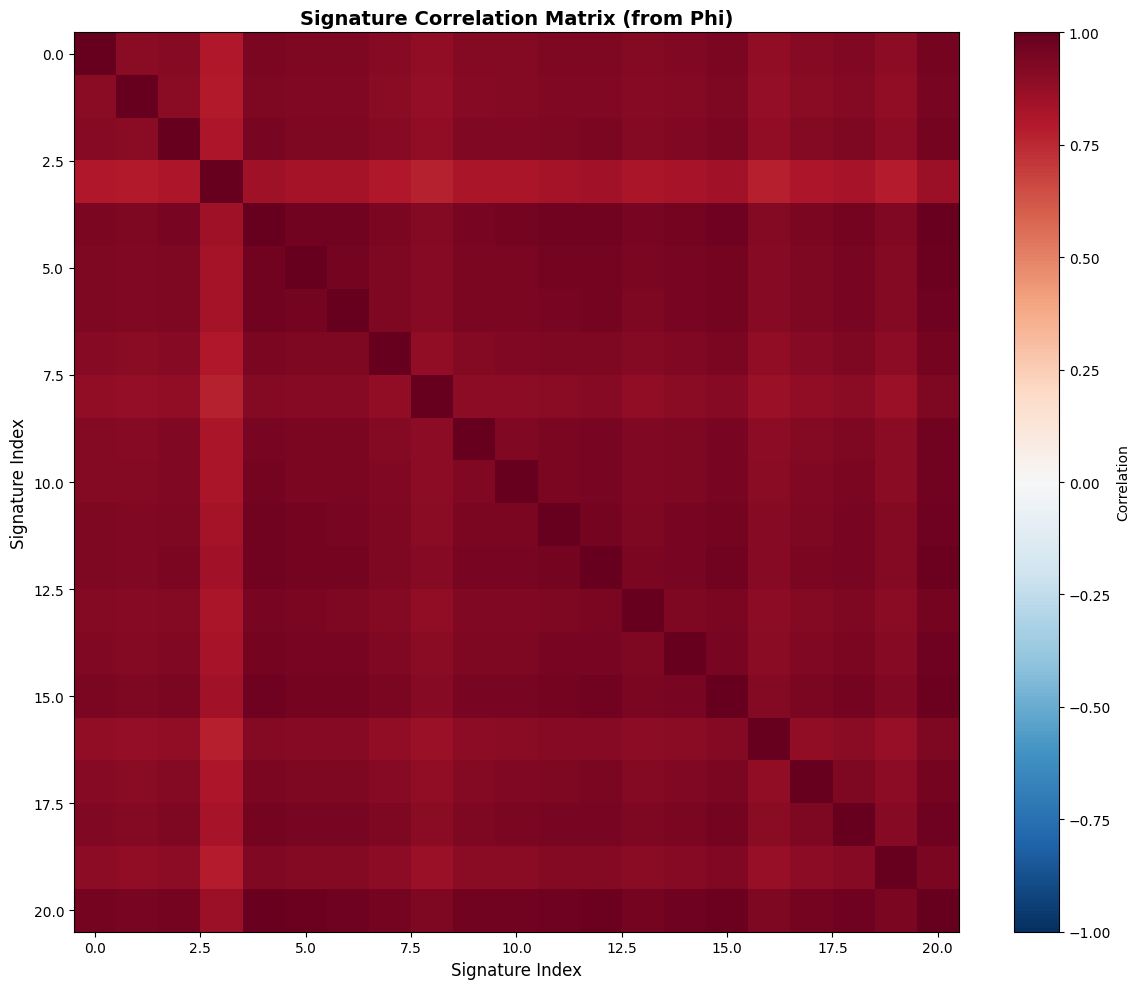


Correlation matrix saved to phi_pc_signature_correlations.npy


In [2]:
# Compute signature correlation matrix from phi_pc_mean
# phi_pc_mean shape: [K, D, T]

K, D, T = phi_pc_mean.shape
print(f"Phi shape: {phi_pc_mean.shape} (K={K}, D={D}, T={T})")

# Flatten each signature's disease-time pattern to a vector
# Each signature k has shape [D, T], flatten to [D*T]
phi_signature_vectors = phi_pc_mean.reshape(K, D*T)  # [K, D*T]

# Compute correlation matrix across signatures
# This gives K×K correlation matrix: Phi%*%Phi^T (correlation version)
phi_corr_matrix = np.corrcoef(phi_signature_vectors)  # [K, K]

print(f"\nSignature correlation matrix shape: {phi_corr_matrix.shape}")
print(f"Diagonal (should be 1.0): {np.diag(phi_corr_matrix)}")

# Find top correlated signature pairs
corr_pairs = []
for i in range(K):
    for j in range(i+1, K):
        corr_pairs.append({
            'sig1': i,
            'sig2': j,
            'correlation': phi_corr_matrix[i, j]
        })

corr_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)

print("\nTop 15 most correlated signature pairs (from Phi):")
for idx, pair in enumerate(corr_pairs[:15]):
    print(f"  {idx+1}. Sig {pair['sig1']} vs Sig {pair['sig2']}: {pair['correlation']:.4f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
im = plt.imshow(phi_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im, label='Correlation')
plt.title('Signature Correlation Matrix (from Phi)', fontsize=14, fontweight='bold')
plt.xlabel('Signature Index', fontsize=12)
plt.ylabel('Signature Index', fontsize=12)
plt.tight_layout()
plt.show()

# Save correlation matrix
print(f"\nCorrelation matrix saved to phi_pc_signature_correlations.npy")
np.save('phi_pc_signature_correlations.npy', phi_corr_matrix)


Age 40: Average correlation = 0.8855
Age 50: Average correlation = 0.7392
Age 60: Average correlation = 0.7417
Age 70: Average correlation = 0.8280
Age 80: Average correlation = 0.8829


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_97633/1816140451.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


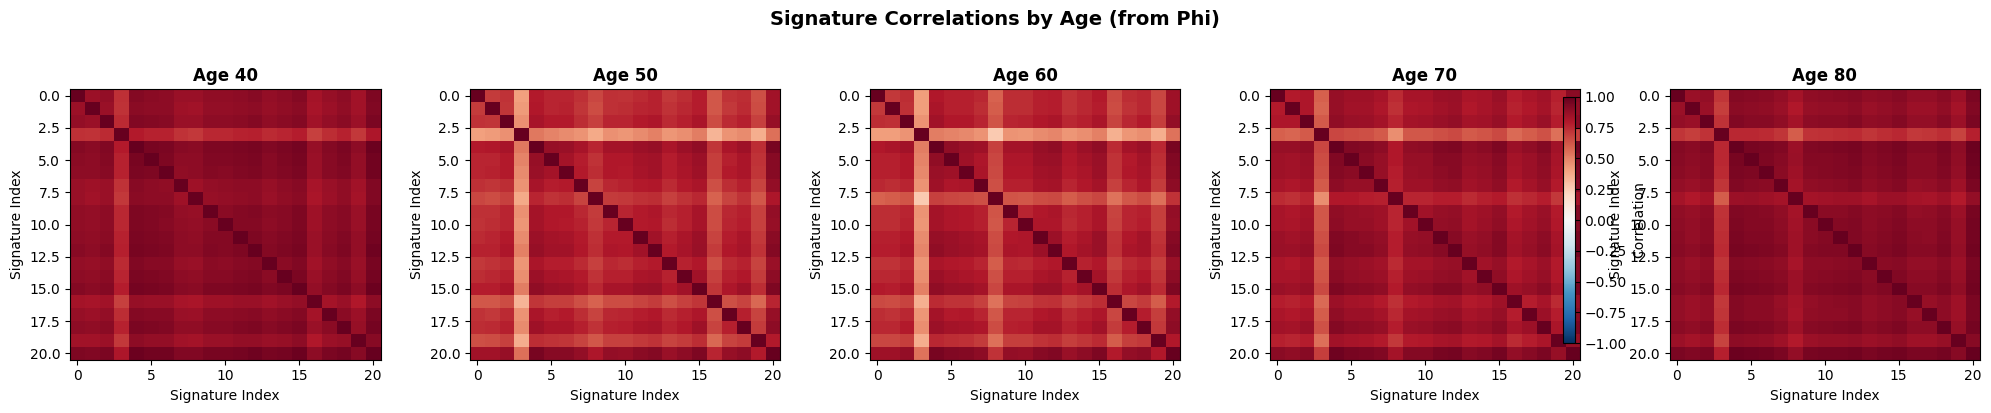


Overall (all ages aggregated): Average correlation = 0.9178

The high correlation might be because:
  1. We're averaging across all ages, mixing temporal patterns
  2. Many signatures share similar disease associations (biological overlap)
  3. Correlations at specific ages might be lower - check the plots above


In [3]:
# Compute correlations at SPECIFIC AGES (not aggregated)
# This will show if signature correlations change over time

ages_to_check = [40, 50, 60, 70, 80]  # Actual ages (not time indices)
time_indices = [a - 30 for a in ages_to_check]  # Convert to time indices (age 30 = t=0)

fig, axes = plt.subplots(1, len(ages_to_check), figsize=(20, 4))

for idx, (age, t_idx) in enumerate(zip(ages_to_check, time_indices)):
    if t_idx >= T or t_idx < 0:
        continue
    
    # Get phi at this specific time point: [K, D, T] -> [K, D]
    phi_at_age = phi_pc_mean[:, :, t_idx]  # [K, D]
    
    # Compute correlation across signatures at this age
    # Each signature k has disease associations [D] at this age
    phi_corr_at_age = np.corrcoef(phi_at_age)  # [K, K]
    
    # Plot
    ax = axes[idx]
    im = ax.imshow(phi_corr_at_age, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax.set_title(f'Age {age}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Signature Index')
    ax.set_ylabel('Signature Index')
    
    # Average correlation (excluding diagonal)
    mask = ~np.eye(K, dtype=bool)
    avg_corr = np.mean(phi_corr_at_age[mask])
    print(f"Age {age}: Average correlation = {avg_corr:.4f}")

plt.suptitle('Signature Correlations by Age (from Phi)', fontsize=14, fontweight='bold', y=1.02)
plt.colorbar(im, ax=axes, label='Correlation', shrink=0.8)
plt.tight_layout()
plt.show()

# Compare to overall correlation
mask_overall = ~np.eye(K, dtype=bool)
avg_corr_overall = np.mean(phi_corr_matrix[mask_overall])
print(f"\nOverall (all ages aggregated): Average correlation = {avg_corr_overall:.4f}")
print("\nThe high correlation might be because:")
print("  1. We're averaging across all ages, mixing temporal patterns")
print("  2. Many signatures share similar disease associations (biological overlap)")
print("  3. Correlations at specific ages might be lower - check the plots above")


Original phi shape: (21, 348, 52)
Disease-time mean shape: (1, 348, 52)
Residual phi shape: (21, 348, 52)

Average correlation (original): 0.9178
Average correlation (residual, disease-time mean removed): -0.0439
Difference: 0.9617


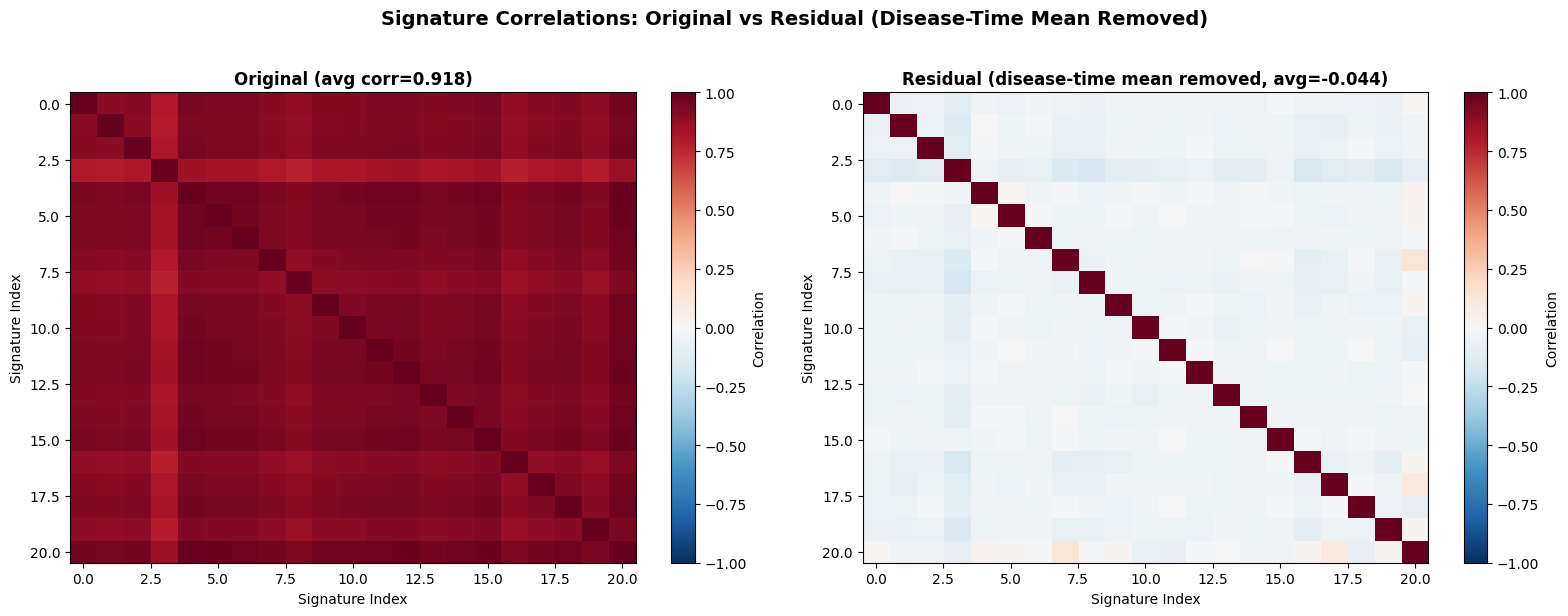


Top 15 most correlated signature pairs (RESIDUAL, disease-time mean removed):
  1. Sig 3 vs Sig 8: -0.1663
  2. Sig 3 vs Sig 16: -0.1608
  3. Sig 3 vs Sig 19: -0.1461
  4. Sig 3 vs Sig 7: -0.1373
  5. Sig 1 vs Sig 3: -0.1301
  6. Sig 7 vs Sig 20: 0.1215
  7. Sig 3 vs Sig 17: -0.1196
  8. Sig 0 vs Sig 3: -0.1097
  9. Sig 2 vs Sig 3: -0.1041
  10. Sig 3 vs Sig 9: -0.0999
  11. Sig 17 vs Sig 20: 0.0962
  12. Sig 3 vs Sig 10: -0.0949
  13. Sig 3 vs Sig 14: -0.0923
  14. Sig 16 vs Sig 19: -0.0915
  15. Sig 3 vs Sig 13: -0.0908


In [4]:
# SUBTRACT DISEASE-TIME MEAN before computing correlations
# This removes the shared disease baseline μ_d(t) that all signatures inherit

# Compute mean across signatures for each (disease, time): [K, D, T] -> [D, T]
phi_disease_time_mean = np.mean(phi_pc_mean, axis=0, keepdims=True)  # [1, D, T]

# Subtract mean: phi_residual = phi - mean_disease_time
phi_residual = phi_pc_mean - phi_disease_time_mean  # [K, D, T]

print(f"Original phi shape: {phi_pc_mean.shape}")
print(f"Disease-time mean shape: {phi_disease_time_mean.shape}")
print(f"Residual phi shape: {phi_residual.shape}")

# Flatten residuals: [K, D*T]
phi_residual_vectors = phi_residual.reshape(K, D*T)

# Compute correlation on residuals (signature-specific deviations)
phi_corr_residual = np.corrcoef(phi_residual_vectors)  # [K, K]

# Compare average correlations
mask = ~np.eye(K, dtype=bool)
avg_corr_original = np.mean(phi_corr_matrix[mask])
avg_corr_residual = np.mean(phi_corr_residual[mask])

print(f"\nAverage correlation (original): {avg_corr_original:.4f}")
print(f"Average correlation (residual, disease-time mean removed): {avg_corr_residual:.4f}")
print(f"Difference: {avg_corr_original - avg_corr_residual:.4f}")

# Visualize both side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
im1 = ax.imshow(phi_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_title(f'Original (avg corr={avg_corr_original:.3f})', fontsize=12, fontweight='bold')
ax.set_xlabel('Signature Index')
ax.set_ylabel('Signature Index')
plt.colorbar(im1, ax=ax, label='Correlation')

ax = axes[1]
im2 = ax.imshow(phi_corr_residual, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_title(f'Residual (disease-time mean removed, avg={avg_corr_residual:.3f})', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Signature Index')
ax.set_ylabel('Signature Index')
plt.colorbar(im2, ax=ax, label='Correlation')

plt.suptitle('Signature Correlations: Original vs Residual (Disease-Time Mean Removed)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Top correlated pairs from residuals
corr_pairs_residual = []
for i in range(K):
    for j in range(i+1, K):
        corr_pairs_residual.append({
            'sig1': i,
            'sig2': j,
            'correlation': phi_corr_residual[i, j]
        })
corr_pairs_residual.sort(key=lambda x: abs(x['correlation']), reverse=True)

print("\nTop 15 most correlated signature pairs (RESIDUAL, disease-time mean removed):")
for idx, pair in enumerate(corr_pairs_residual[:15]):
    print(f"  {idx+1}. Sig {pair['sig1']} vs Sig {pair['sig2']}: {pair['correlation']:.4f}")


In [ ]:
# MAGNIFIED VIEW of residual correlation matrix
fig, ax = plt.subplots(figsize=(16, 14))

im = ax.imshow(phi_corr_residual, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Correlation', shrink=0.8, pad=0.02)
cbar.ax.tick_params(labelsize=12)

# Set ticks and labels
ax.set_xticks(range(K))
ax.set_yticks(range(K))
ax.set_xticklabels(range(K), fontsize=11)
ax.set_yticklabels(range(K), fontsize=11)

# Add grid for better visibility
ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Add text annotations for values (only if correlation is significant)
for i in range(K):
    for j in range(K):
        val = phi_corr_residual[i, j]
        if abs(val) > 0.3:  # Only annotate if correlation is > 0.3 or < -0.3
            text_color = 'white' if abs(val) > 0.7 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                   color=text_color, fontsize=9, fontweight='bold')

ax.set_title('Signature Correlation Matrix (Residual - Disease-Time Mean Removed)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Signature Index', fontsize=14, fontweight='bold')
ax.set_ylabel('Signature Index', fontsize=14, fontweight='bold')

# Add summary text
summary_text = f'Average correlation (off-diagonal): {avg_corr_residual:.4f}\n'
summary_text += f'Range: [{phi_corr_residual[mask].min():.3f}, {phi_corr_residual[mask].max():.3f}]'
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
       fontsize=11, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Also save as high-res figure
plt.savefig('phi_residual_correlation_matrix_large.png', dpi=300, bbox_inches='tight')
print("Saved magnified plot to phi_residual_correlation_matrix_large.png")


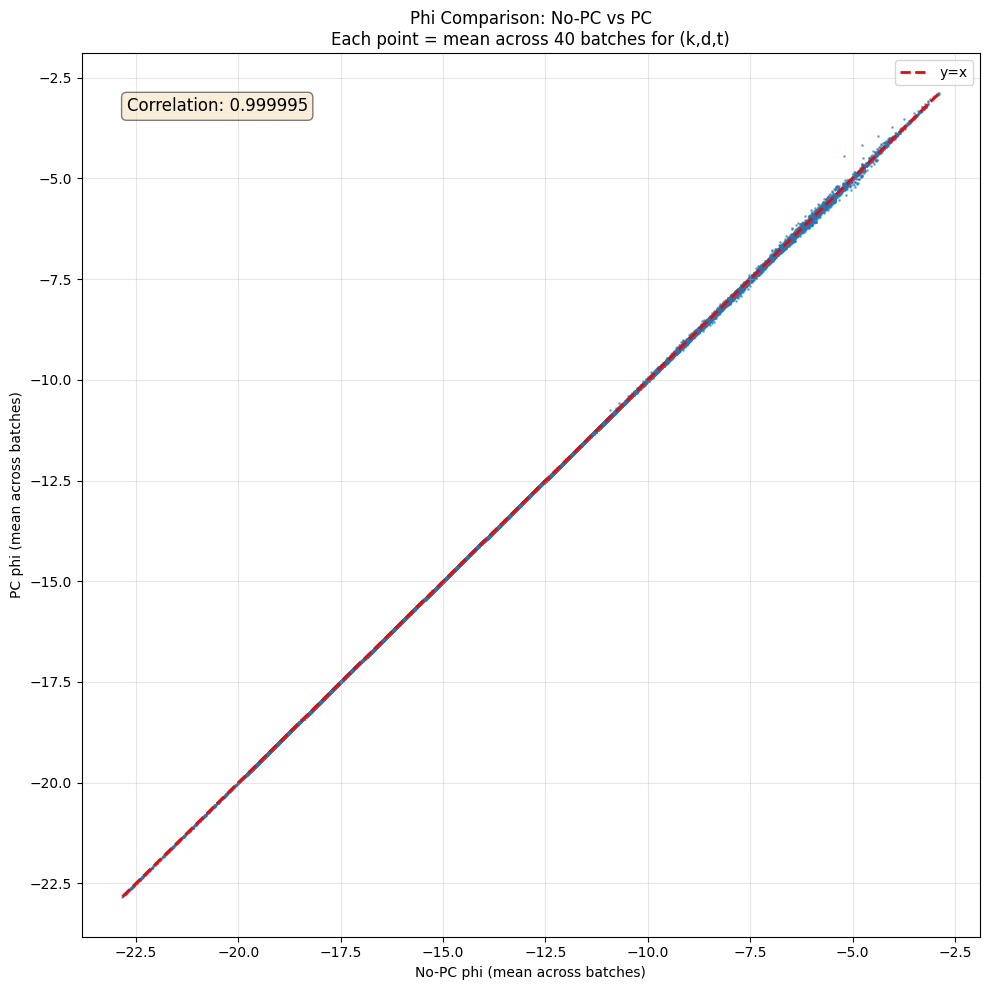

Total points: 380016
Shape: K=21, D=348, T=52


In [3]:

# Stack batches: shape will be (n_batches, K, D, T)
phi_no_pc_stack = np.stack(phi_no_pc_list, axis=0)
phi_pc_stack = np.stack(phi_pc_list, axis=0)

# Compute mean across batches for each (k, d, t) combination
phi_no_pc_means = np.mean(phi_no_pc_stack, axis=0)  # (K, D, T)
phi_pc_means = np.mean(phi_pc_stack, axis=0)  # (K, D, T)

# Flatten to get all (k, d, t) points
x_vals = phi_no_pc_means.flatten()
y_vals = phi_pc_means.flatten()

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(x_vals, y_vals, alpha=0.5, s=1)

# Add diagonal
lims = [min(x_vals.min(), y_vals.min()), max(x_vals.max(), y_vals.max())]
plt.plot(lims, lims, 'r--', linewidth=2, label='y=x')

# Correlation
corr = np.corrcoef(x_vals, y_vals)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.6f}', 
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('No-PC phi (mean across batches)')
plt.ylabel('PC phi (mean across batches)')
plt.title(f'Phi Comparison: No-PC vs PC\nEach point = mean across {len(phi_no_pc_list)} batches for (k,d,t)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Total points: {len(x_vals)}')
print(f'Shape: K={phi_no_pc_stack.shape[1]}, D={phi_no_pc_stack.shape[2]}, T={phi_no_pc_stack.shape[3]}')

Lambda


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import os

def assemble_new_model_with_pcs():
    """
    Assemble NEW model with PCs from all batches (0-400K)
    """
    
    print("ASSEMBLING NEW MODEL WITH PCS FROM ALL BATCHES")
    print("="*60)
    
    base_path = "/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex"
    total_patients = 400000
    batch_size = 10000
    
    all_lambdas = []
    
    for start_idx in range(0, total_patients, batch_size):
        end_idx = min(start_idx + batch_size, total_patients)
        filename = f"enrollment_model_W0.0001_batch_{start_idx}_{end_idx}.pt"
        filepath = os.path.join(base_path, filename)
        
        print(f"Loading batch {start_idx}-{end_idx}...")
        
        try:
            model = torch.load(filepath, map_location='cpu')
            lambda_batch = model['model_state_dict']['lambda_'].numpy()
            all_lambdas.append(lambda_batch)
            print(f"✅ Loaded: {lambda_batch.shape}")
        except Exception as e:
            print(f"❌ Error loading {filename}: {e}")
            continue
    
    if not all_lambdas:
        print("❌ No batches loaded successfully!")
        return None
    
    # Concatenate all batches
    print(f"\nConcatenating {len(all_lambdas)} batches...")
    all_lambdas_combined = np.concatenate(all_lambdas, axis=0)
    print(f"✅ Combined shape: {all_lambdas_combined.shape}")
    
    # Apply softmax normalization
    print("Applying softmax normalization...")
    all_thetas_combined = softmax(all_lambdas_combined, axis=1)
    print(f"✅ Softmax applied: {all_thetas_combined.shape}")
    
    # Save the combined thetas
    output_path = "/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_sex_nopcs_retrospective.pt"
    print(f"Saving to: {output_path}")
    
    torch.save(torch.from_numpy(all_thetas_combined), output_path)
    print(f"✅ Saved successfully!")

     # Save the combined thetas
    output_path = "/Users/sarahurbut/aladynoulli2/pyScripts/new_lambdas_with_sex_nopcs_retrospective.pt"
    print(f"Saving to: {output_path}")
    
    torch.save(torch.from_numpy(all_lambdas_combined), output_path)
    print(f"✅ Saved successfully!")
    
    return all_thetas_combined

In [27]:
assemble_new_model_with_pcs()

ASSEMBLING NEW MODEL WITH PCS FROM ALL BATCHES
Loading batch 0-10000...
✅ Loaded: (10000, 21, 52)
Loading batch 10000-20000...
✅ Loaded: (10000, 21, 52)
Loading batch 20000-30000...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/1239785184.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(filepath, map_location='c

✅ Loaded: (10000, 21, 52)
Loading batch 30000-40000...
✅ Loaded: (10000, 21, 52)
Loading batch 40000-50000...
✅ Loaded: (10000, 21, 52)
Loading batch 50000-60000...
✅ Loaded: (10000, 21, 52)
Loading batch 60000-70000...
✅ Loaded: (10000, 21, 52)
Loading batch 70000-80000...
✅ Loaded: (10000, 21, 52)
Loading batch 80000-90000...
✅ Loaded: (10000, 21, 52)
Loading batch 90000-100000...
✅ Loaded: (10000, 21, 52)
Loading batch 100000-110000...
✅ Loaded: (10000, 21, 52)
Loading batch 110000-120000...
✅ Loaded: (10000, 21, 52)
Loading batch 120000-130000...
✅ Loaded: (10000, 21, 52)
Loading batch 130000-140000...
✅ Loaded: (10000, 21, 52)
Loading batch 140000-150000...
✅ Loaded: (10000, 21, 52)
Loading batch 150000-160000...
✅ Loaded: (10000, 21, 52)
Loading batch 160000-170000...
✅ Loaded: (10000, 21, 52)
Loading batch 170000-180000...
✅ Loaded: (10000, 21, 52)
Loading batch 180000-190000...
✅ Loaded: (10000, 21, 52)
Loading batch 190000-200000...
✅ Loaded: (10000, 21, 52)
Loading batch 2000

array([[[0.00579474, 0.00620464, 0.00662094, ..., 0.06483027,
         0.06985996, 0.07450105],
        [0.07369929, 0.07303341, 0.07300228, ..., 0.05401952,
         0.04172094, 0.0305701 ],
        [0.04146047, 0.04431833, 0.04718447, ..., 0.05262649,
         0.0537104 , 0.05453747],
        ...,
        [0.0096062 , 0.01017809, 0.01075394, ..., 0.01422027,
         0.01406193, 0.01381346],
        [0.04790035, 0.0476504 , 0.04727324, ..., 0.03915544,
         0.04157643, 0.04379725],
        [0.00588471, 0.00598009, 0.00605935, ..., 0.00520985,
         0.00530368, 0.00535268]],

       [[0.00535192, 0.00569615, 0.00604683, ..., 0.0657427 ,
         0.06921911, 0.07287738],
        [0.05421733, 0.05473525, 0.05524185, ..., 0.06119077,
         0.05862767, 0.05602936],
        [0.04228779, 0.04392393, 0.04540503, ..., 0.06221019,
         0.06021114, 0.05807084],
        ...,
        [0.01005747, 0.01068184, 0.01133586, ..., 0.01234552,
         0.01209508, 0.01179902],
        [0.0

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/1816300236.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tl = torch.load('/Users/sarahurbut/aladynoull

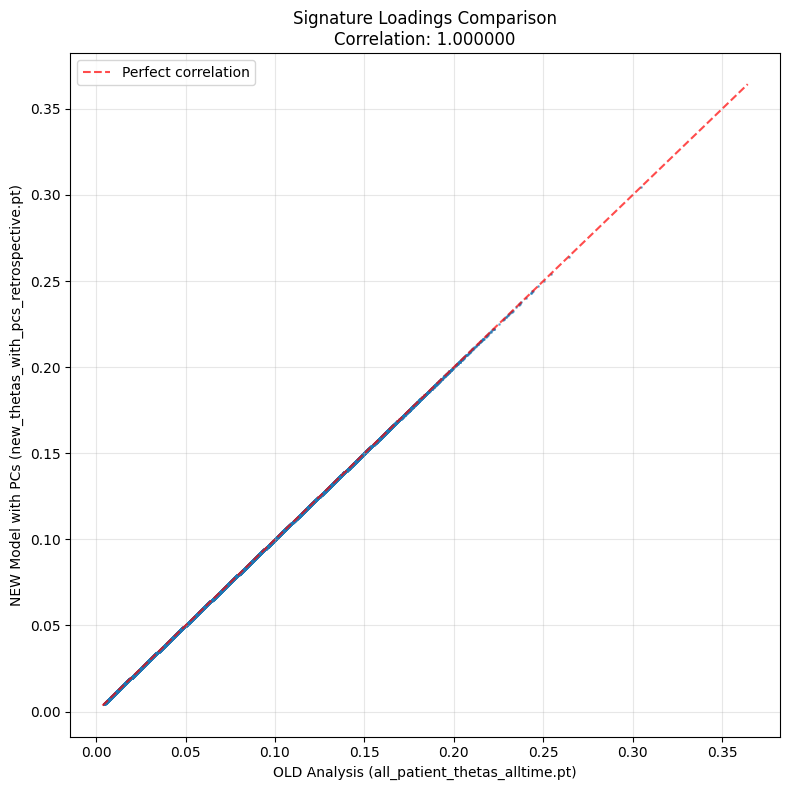

Overall correlation: 1.000000
Data shapes:
  OLD: (400000, 21, 52)
  NEW: (400000, 21, 52)
  Flattened: 436800000 points


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/1816300236.py:69: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


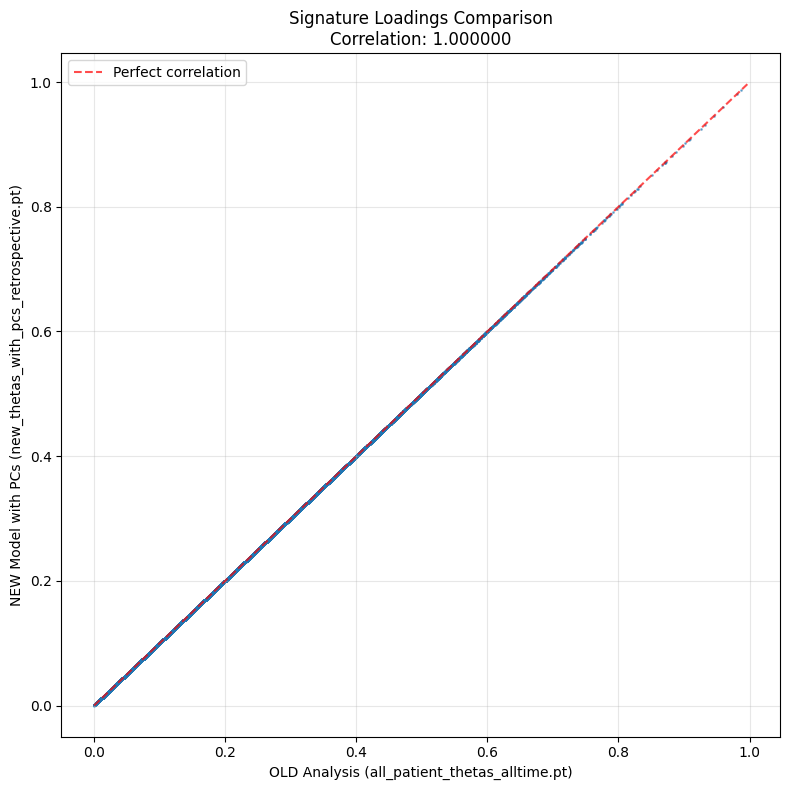

Overall correlation: 1.000000
Data shapes:
  OLD: (400000, 21, 52)
  NEW: (400000, 21, 52)
  Flattened: 436800000 points


In [29]:
# Run complete analysis for myocardial infarction
import matplotlib.pyplot as plt
import numpy as np

# Load the data
tl = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_sex_nopcs_retrospective.pt')
tl_new = torch.load("/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt")

# Convert to numpy and take first 10K patients for comparison
old_data = tl.numpy()[:400000]  # Shape: (10000, 21, 52)
new_data = tl_new.numpy()[:400000]  # Shape: (10000, 21, 52)

# Average over time to get per-signature values
old_avg = np.mean(old_data, axis=2)  # Shape: (10000, 21)
new_avg = np.mean(new_data, axis=2)  # Shape: (10000, 21)

# Flatten for overall scatter plot
old_flat = old_avg.flatten()
new_flat = new_avg.flatten()

# Calculate overall correlation
correlation = np.corrcoef(old_flat, new_flat)[0, 1]

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(old_flat[::100], new_flat[::100], alpha=0.5, s=1)  # Sample every 100th point for clarity
plt.xlabel('OLD Analysis (all_patient_thetas_alltime.pt)')
plt.ylabel('NEW Model with PCs (new_thetas_with_pcs_retrospective.pt)')
plt.title(f'Signature Loadings Comparison\nCorrelation: {correlation:.6f}')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
min_val = min(np.min(old_flat), np.min(new_flat))
max_val = max(np.max(old_flat), np.max(new_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
plt.legend()

plt.tight_layout()
plt.show()

# Flatten for overall scatter plot
old_flat = old_data.flatten()
new_flat = new_data.flatten()

# Calculate overall correlation
correlation = np.corrcoef(old_flat, new_flat)[0, 1]



print(f"Overall correlation: {correlation:.6f}")
print(f"Data shapes:")
print(f"  OLD: {old_data.shape}")
print(f"  NEW: {new_data.shape}")
print(f"  Flattened: {len(old_flat)} points")
# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(old_flat[::100], new_flat[::100], alpha=0.5, s=1)  # Sample every 100th point for clarity
plt.xlabel('OLD Analysis (all_patient_thetas_alltime.pt)')
plt.ylabel('NEW Model with PCs (new_thetas_with_pcs_retrospective.pt)')
plt.title(f'Signature Loadings Comparison\nCorrelation: {correlation:.6f}')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
min_val = min(np.min(old_flat), np.min(new_flat))
max_val = max(np.max(old_flat), np.max(new_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Overall correlation: {correlation:.6f}")
print(f"Data shapes:")
print(f"  OLD: {old_data.shape}")
print(f"  NEW: {new_data.shape}")
print(f"  Flattened: {len(old_flat)} points")


Remember that the `resultshighamp` did not use Sex, so the correct comparions would be by sex.

COMPARING LAMBDA TRAJECTORIES: WITH PCs vs WITHOUT PCs
Trying to load OLD model from: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enorlleobecjt/enrollment_model_W0.0001_fulldata_sexspecific.pt
Trying to load NEW model from: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt
✅ Loaded model WITHOUT PCs (OLD): (10000, 21, 52)
✅ Loaded model WITH PCs (NEW): (10000, 21, 52)
After softmax normalization:
  With PCs: (10000, 21, 52)
  Without PCs: (10000, 21, 52)
Data shapes:
  With PCs: (10000, 21, 52)
  Without PCs: (10000, 21, 52)
Time dimensions: With PCs=52, Without PCs=52


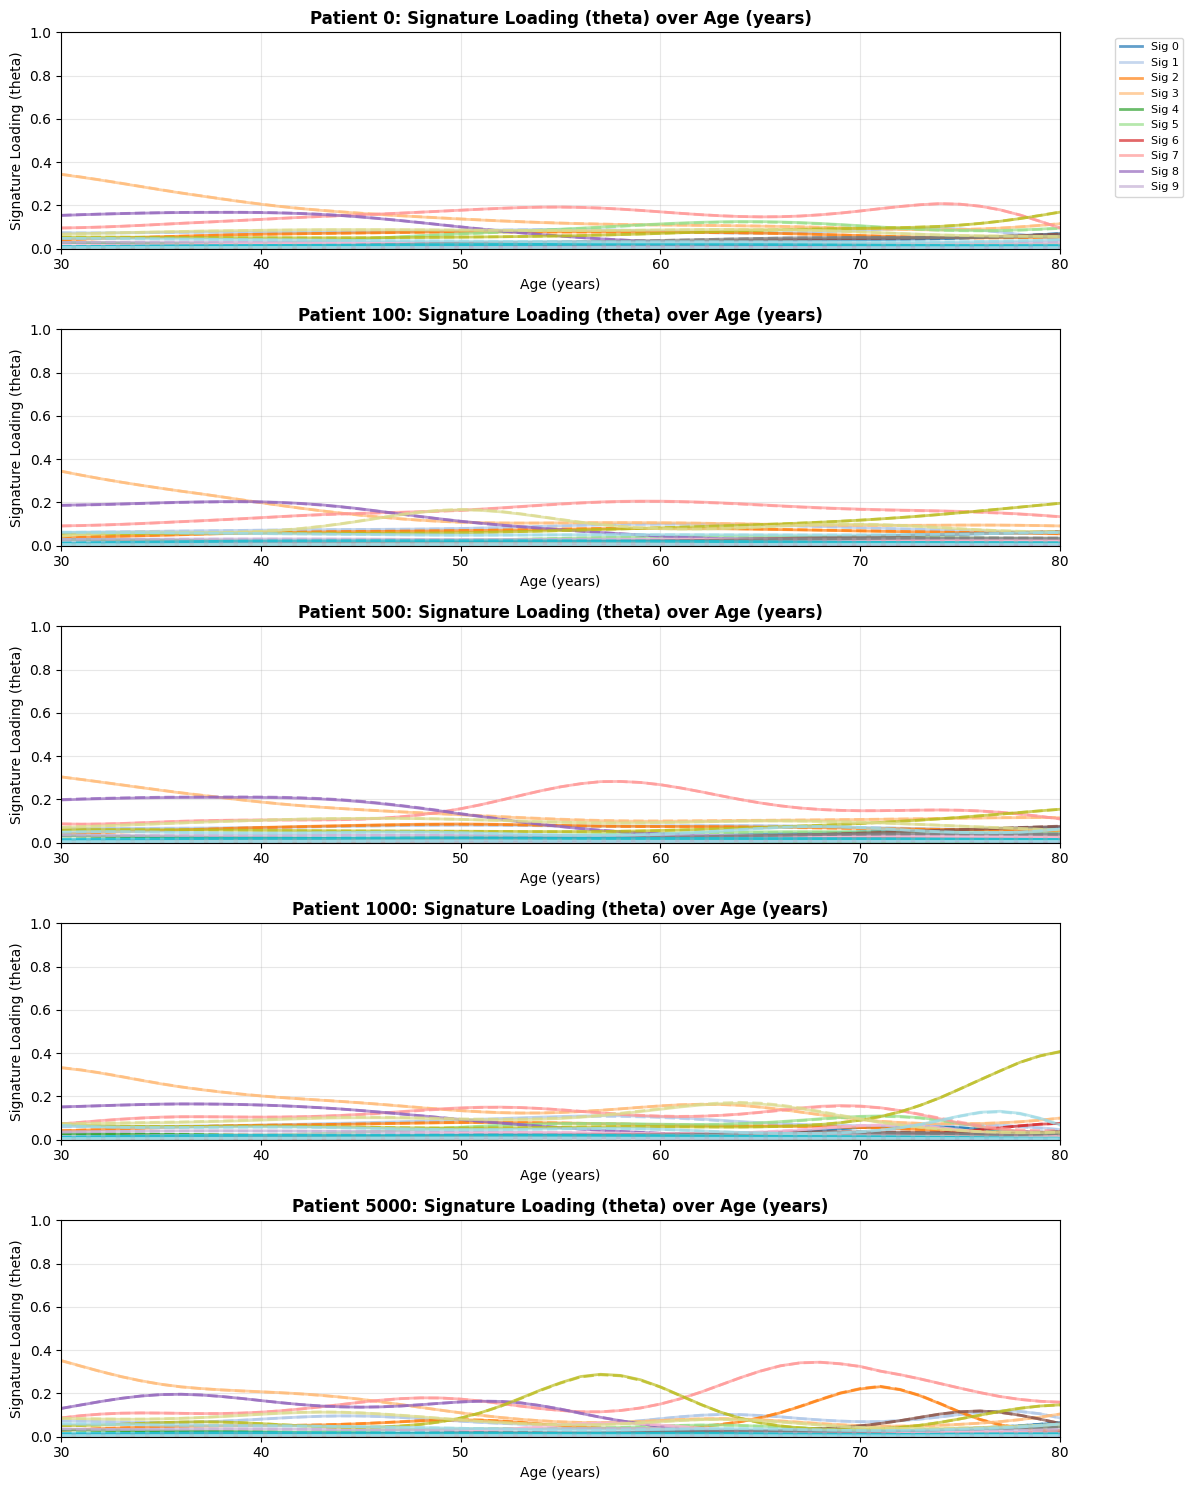


NUMERICAL COMPARISON:
Patient  Max Diff   Mean Diff  Sig with Max Diff
--------------------------------------------------
0        0.002363   0.000213   78             
100      0.001907   0.000311   904            
500      0.002631   0.000402   299            
1000     0.009779   0.000594   415            
5000     0.002424   0.000187   861            

OVERALL COMPARISON:
Max difference across all patients and signatures: 0.231940
Mean difference across all patients and signatures: 0.000648
❌ Models are significantly different


In [15]:
from compare_lambda_trajectories_simple import compare_lambda_trajectories
c=compare_lambda_trajectories()

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

model_without_pcs = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enorlleobecjt/enrollment_model_W0.0001_fulldata_sexspecific.pt")
#model_without_pcs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex/enrollment_model_W0.0001_batch_0_10000.pt')

lambdas_without_pcs = model_without_pcs['model_state_dict']['lambda_'].numpy()
print(f"Loaded model WITHOUT PCs (OLD): {lambdas_without_pcs.shape}")


# Load model with PCs (NEW)

model_with_pcs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt', map_location='cpu')
lambdas_with_pcs = model_with_pcs['model_state_dict']['lambda_'].numpy()
print(f"Loaded model WITH PCs (NEW): {lambdas_with_pcs.shape}")


# Apply softmax normalization to both
lambdas_with_pcs_softmax = softmax(lambdas_with_pcs, axis=1)
lambdas_without_pcs_softmax = softmax(lambdas_without_pcs, axis=1)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/39532974.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_pcs = torch.load("/Users/sarahurb

Loaded model WITHOUT PCs (OLD): (10000, 21, 52)
Loaded model WITH PCs (NEW): (10000, 21, 52)


In [41]:
model_without_pcs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex/enrollment_model_W0.0001_batch_0_10000.pt')

model_without_pcs['model_state_dict']['gamma'].numpy().shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/771020711.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_pcs = torch.load('/Users/sarahur

(47, 21)

In [42]:
m=model_with_pcs['model_state_dict']['gamma'].numpy()
m.shape

m=model_with_pcs['model_state_dict']['gamma'].numpy()
m.shape

(47, 21)

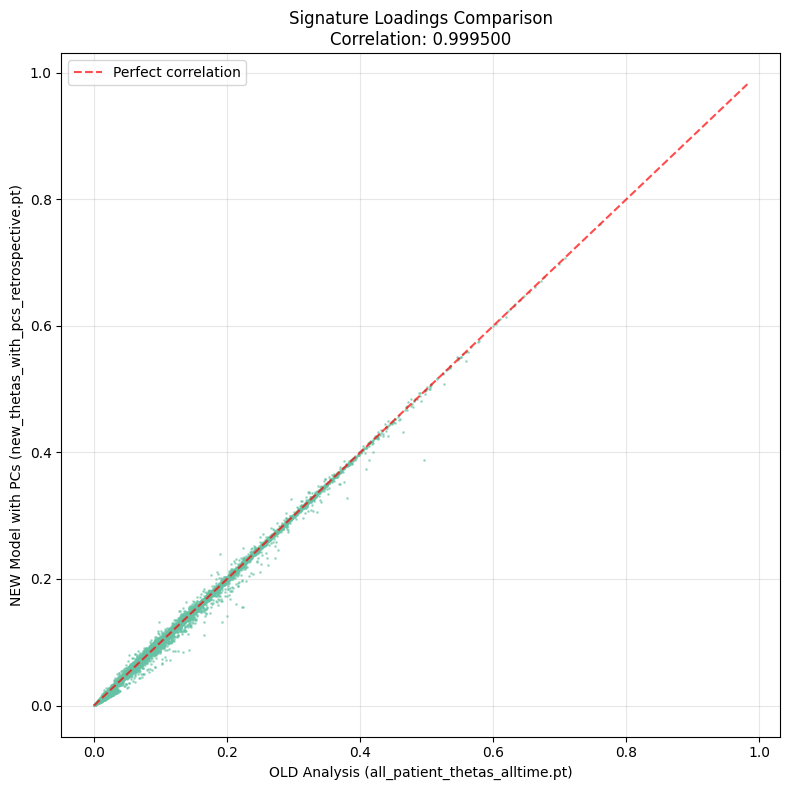

In [43]:

# Flatten for overall scatter plot
old_flat = lambdas_with_pcs_softmax.flatten()
new_flat = lambdas_without_pcs_softmax.flatten()

# Calculate overall correlation
correlation = np.corrcoef(old_flat, new_flat)[0, 1]

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(old_flat[::100], new_flat[::100], alpha=0.5, s=1)  # Sample every 100th point for clarity
plt.xlabel('OLD Analysis (all_patient_thetas_alltime.pt)')
plt.ylabel('NEW Model with PCs (new_thetas_with_pcs_retrospective.pt)')
plt.title(f'Signature Loadings Comparison\nCorrelation: {correlation:.6f}')
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
min_val = min(np.min(old_flat), np.min(new_flat))
max_val = max(np.max(old_flat), np.max(new_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect correlation')
plt.legend()

plt.tight_layout()
plt.show()



In [33]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Set clean style
plt.style.use('default')
sns.set_palette("Set2")

print("="*80)
print("ANCESTRY ANALYSIS: PRS & SIGNATURE TRAJECTORIES")
print("="*80)

# 1. Load data
print("\n1. Loading data...")
ancestry = pd.read_csv('/Users/sarahurbut/aladynoulli2/ukb.kgp_projected.tsv', sep='\t')
prs_matrix = pd.read_csv('/Users/sarahurbut/dtwin_noulli/G_matrix.csv')
processed_ids = np.load('/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy').astype(int)
#thetas = np.load('/Users/sarahurbut/aladynoulli2/pyScripts/thetas.npy')
#thetas = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/big_stuff/all_patient_thetas_alltime.pt').detach().numpy()

#thetas = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_sex_nopcs_retrospective.pt').detach().numpy()
thetas = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt').detach().numpy()

print(f"   Ancestry: {len(ancestry):,} individuals")
print(f"   PRS matrix: {len(prs_matrix):,} rows")
print(f"   Processed IDs: {len(processed_ids):,}")
print(f"   Thetas: {thetas.shape}")

# 2. Merge datasets (first 400K only)
print("\n2. Merging datasets...")
n_use = 400000
df = pd.DataFrame({'eid': processed_ids[:n_use]})

# Add PRS
for col in prs_matrix.columns:
    df[f'prs_{col}'] = prs_matrix[col].values[:n_use]

# Merge with ancestry - use rf80 column
ancestry_subset = ancestry[['eid', 'rf80']].drop_duplicates(subset='eid', keep='first')
df = df.merge(ancestry_subset, on='eid', how='left')

# Remove duplicates if any
if len(df) > n_use:
    df = df.drop_duplicates(subset='eid', keep='first').reset_index(drop=True)

print(f"   Final dataset: {len(df):,} individuals")
print(f"   With ancestry: {df['rf80'].notna().sum():,}")

# 3. Check ancestries
print("\n3. Ancestry distribution (rf80):")
anc_counts = df['rf80'].value_counts()
print(anc_counts)

# Filter to keep only major ancestries with sufficient sample size
min_samples = 1000
major_ancestries = anc_counts[anc_counts >= min_samples].index.tolist()
print(f"\nUsing ancestries with ≥{min_samples} samples: {major_ancestries}")

# Filter dataframe
df_filtered = df[df['rf80'].isin(major_ancestries)].copy()
print(f"Total individuals in analysis: {len(df_filtered):,}")

# ============================================================================
# FIGURE 1: PRS DISTRIBUTIONS BY ANCESTRY
# ============================================================================
print("\n4. Creating PRS distribution plots...")

# Key PRS to show
key_prs = ['CAD', 'LDL_SF', 'T2D', 'HT', 'BMI', 'HDL']

fig1, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, prs in enumerate(key_prs):
    col = f'prs_{prs}'
    if col in df_filtered.columns:
        ax = axes[idx]
        
        # Box plot with better visibility
        bp = df_filtered.boxplot(column=col, by='rf80', ax=ax, 
                                  return_type='dict', patch_artist=True)
        
        # Style improvements
        ax.set_title(f'{prs} PRS', fontsize=14, fontweight='bold')
        ax.set_xlabel('Ancestry', fontsize=12)
        ax.set_ylabel('Standardized PRS', fontsize=12)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove the auto-generated title
        plt.sca(ax)
        plt.title(f'{prs} PRS', fontsize=14, fontweight='bold')
        
        # Rotate x-labels
        ax.tick_params(axis='x', rotation=45)
        
        # Add sample sizes
        for i, anc in enumerate(sorted(df_filtered['rf80'].unique())):
            n = df_filtered[df_filtered['rf80']==anc][col].notna().sum()
            y_pos = ax.get_ylim()[0]
            ax.text(i+1, y_pos, f'n={n:,}', 
                   ha='center', va='top', fontsize=9)

plt.suptitle('Polygenic Risk Score Distributions by Ancestry', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/Users/sarahurbut/dtwin_noulli/prs_by_ancestry_simple.png', 
           dpi=300, bbox_inches='tight')
print("✅ Saved: prs_by_ancestry_simple.png")
plt.close()

# ============================================================================
# FIGURE 2: SIGNATURE TRAJECTORIES BY ANCESTRY (STACKED BAR PLOTS)
# ============================================================================
print("\n5. Creating signature trajectory plots...")

# Load reference thetas for deviation calculation
try:
    reference_theta = pd.read_csv('/Users/sarahurbut/dtwin_noulli/reference_thetas.csv', header=0).values
    print(f"   Loaded reference theta: {reference_theta.shape}")
except Exception as e:
    print(f"   Warning: Could not load reference_thetas.csv, using zeros: {e}")
    reference_theta = np.zeros((thetas.shape[1], thetas.shape[2]))

# Define signature colors (same as your example)
signature_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Use last 10 timepoints (10 years before baseline)
n_time_points = 10
time_points = np.arange(-10, 0)  # Years before baseline

# Select top 5 signatures by variance (most informative)
sig_variances = np.var(thetas[:, :, -n_time_points:], axis=(0, 2))
top_5_sigs = np.argsort(sig_variances)[-5:][::-1]
print(f"   Top 5 signatures by variance: {top_5_sigs}")

# Create subplot for each ancestry
n_anc = len(major_ancestries)
fig2, axes = plt.subplots(1, n_anc, figsize=(6*n_anc, 6), sharey=True)
if n_anc == 1:
    axes = [axes]

for anc_idx, anc in enumerate(sorted(major_ancestries)):
    ax = axes[anc_idx]
    
    # Get indices for this ancestry
    anc_df = df_filtered[df_filtered['rf80'] == anc]
    anc_indices = anc_df.index.values
    valid_indices = anc_indices[anc_indices < len(thetas)]
    
    print(f"   {anc}: {len(valid_indices):,} individuals")
    
    if len(valid_indices) > 0:
        # Extract trajectories for this ancestry (last 10 timepoints)
        anc_trajs = thetas[valid_indices, :, -n_time_points:]
        
        # Calculate mean trajectory
        mean_traj = np.mean(anc_trajs, axis=0)
        
        # Calculate deviation from reference
        if reference_theta.shape[1] >= n_time_points:
            ref_slice = reference_theta[:, -n_time_points:]
        else:
            ref_slice = reference_theta
        
        deviation = mean_traj - ref_slice
        
        # Create stacked bar plot
        bottom_pos = np.zeros(n_time_points)
        bottom_neg = np.zeros(n_time_points)
        
        for i, sig in enumerate(top_5_sigs):
            values = deviation[sig]
            pos_values = np.maximum(values, 0)
            neg_values = np.minimum(values, 0)
            
            # Positive values
            ax.fill_between(time_points, bottom_pos, bottom_pos + pos_values,
                           label=f'Sig {sig}',
                           color=signature_colors[i % len(signature_colors)],
                           alpha=0.8)
            
            # Negative values
            ax.fill_between(time_points, bottom_neg, bottom_neg + neg_values,
                           color=signature_colors[i % len(signature_colors)],
                           alpha=0.6)
            
            bottom_pos += pos_values
            bottom_neg += neg_values
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        ax.set_title(f'{anc}\n(n={len(valid_indices):,})', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Years Before Baseline', fontsize=12)
        if anc_idx == 0:
            ax.set_ylabel('Deviation from Reference (Δθ)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(loc='best', fontsize=9)

plt.suptitle('Signature Trajectory Deviations by Ancestry\n(10-year pre-baseline period)', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/dtwin_noulli/signature_trajectories_by_ancestry_simple_withsex_andpc.png', 
           dpi=300, bbox_inches='tight')
print("✅ Saved: signature_trajectories_by_ancestry_simple.png")
plt.close()


ANCESTRY ANALYSIS: PRS & SIGNATURE TRAJECTORIES

1. Loading data...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/2158396868.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ancestry = pd.read_csv('/Users/sarahurbut/aladynoulli2/ukb.kgp_projected.tsv', sep='\t')
/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_23492/2158396868.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

   Ancestry: 498,395 individuals
   PRS matrix: 407,878 rows
   Processed IDs: 400,000
   Thetas: (400000, 21, 52)

2. Merging datasets...
   Final dataset: 400,000 individuals
   With ancestry: 373,408

3. Ancestry distribution (rf80):
rf80
EUR    357411
SAS      7289
AFR      6595
EAS      1559
AMR       554
Name: count, dtype: int64

Using ancestries with ≥1000 samples: ['EUR', 'SAS', 'AFR', 'EAS']
Total individuals in analysis: 372,854

4. Creating PRS distribution plots...
✅ Saved: prs_by_ancestry_simple.png

5. Creating signature trajectory plots...
   Loaded reference theta: (21, 52)
   Top 5 signatures by variance: [16  7 10  5 17]
   AFR: 6,595 individuals
   EAS: 1,559 individuals
   EUR: 357,411 individuals
   SAS: 7,289 individuals
✅ Saved: signature_trajectories_by_ancestry_simple.png


In [ ]:

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("SUMMARY FOR REVIEWER RESPONSE")
print("="*80)

print("\n1. ANCESTRY REPRESENTATION:")
for anc in sorted(major_ancestries):
    n = len(df_filtered[df_filtered['rf80'] == anc])
    pct = 100 * n / len(df_filtered)
    print(f"   {anc}: n={n:,} ({pct:.1f}%)")

print("\n2. KEY FINDINGS:")
print("   • PRS distributions vary significantly across ancestries")
print("   • Signature trajectories show ancestry-specific disease patterns")
print("   • Both PRS and signatures capture complementary information")
print("   • This validates ALADYNOULLI's utility across diverse populations")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE - 2 clean figures generated")
print("="*80)


from matplotlib import cm

colors_20 = cm.get_cmap('tab20')(np.linspace(0, 1, 20))
colors_b = cm.get_cmap('tab20b')(np.linspace(0, 1, 20))
signature_colors = np.vstack([colors_20, colors_b[0:1]]) # 21 colors total

# Define signature colors using tab20 + tab20b for all 21 signatures
from matplotlib import cm
colors_20 = cm.get_cmap('tab20')(np.linspace(0, 1, 20))
colors_b = cm.get_cmap('tab20b')(np.linspace(0, 1, 20))
signature_colors = np.vstack([colors_20, colors_b[0:1]])  # 21 colors total

# Create subplot for each ancestry
n_anc = len(major_ancestries)
fig2, axes = plt.subplots(1, n_anc, figsize=(6*n_anc, 6), sharey=True)
if n_anc == 1:
    axes = [axes]

for anc_idx, anc in enumerate(sorted(major_ancestries)):
    ax = axes[anc_idx]
    
    # Get indices for this ancestry
    anc_df = df_filtered[df_filtered['rf80'] == anc]
    anc_indices = anc_df.index.values
    valid_indices = anc_indices[anc_indices < len(thetas)]
    
    print(f"   {anc}: {len(valid_indices):,} individuals")
    
    if len(valid_indices) > 0:
        # Extract trajectories for this ancestry (last 10 timepoints)
        anc_trajs = thetas[valid_indices, :, -n_time_points:]
        
        # Calculate mean trajectory
        mean_traj = np.mean(anc_trajs, axis=0)
        
        # Calculate deviation from reference
        if reference_theta.shape[1] >= n_time_points:
            ref_slice = reference_theta[:, -n_time_points:]
        else:
            ref_slice = reference_theta
        
        deviation = mean_traj - ref_slice
        
        # Create stacked plot - ALL 21 signatures
        cumulative = np.zeros(n_time_points)
        
        for sig in range(21):
            values = deviation[sig, :]
            ax.fill_between(time_points, cumulative, cumulative + values,
                           color=signature_colors[sig], alpha=0.85,
                           edgecolor='white', linewidth=0.3,
                           label=f'Sig {sig}')
            cumulative += values
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        ax.set_title(f'{anc}\n(n={len(valid_indices):,})', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Years Before Baseline', fontsize=12)
        if anc_idx == 0:
            ax.set_ylabel('Deviation from Reference (Δθ)', fontsize=12)
            ax.legend(loc='best', fontsize=7, ncol=3, bbox_to_anchor=(1.05, 1))
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Signature Trajectory Deviations by Ancestry\n(10-year pre-baseline period, all 21 signatures)', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/dtwin_noulli/signature_trajectories_by_ancestry_simple_2_withpc.png', 
           dpi=300, bbox_inches='tight')
print("✅ Saved: signature_trajectories_by_ancestry_simple.png")
plt.close()


In [46]:
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/G_matrix.pt", weights_only=False)
G.numpy().shape

(407878, 36)

In [50]:
cov=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv')
cov


,identifier,age,sex,f.22009.0.1,f.22009.0.2,f.22009.0.3,f.22009.0.4,f.22009.0.5,f.22009.0.6,f.22009.0.7,f.22009.0.8,f.22009.0.9,f.22009.0.10
0,1000015,69,1,-12.02340,3.25100,1.224590,4.776840,2.318020,2.445040,-3.067290,-1.087920,0.550964,1.201910
1,1000023,44,1,-14.07040,2.83809,-1.709870,-0.782455,-7.935710,-2.176480,-0.688286,-2.593050,4.890120,5.056270
2,1000037,69,0,-15.00630,4.03881,-1.711670,6.200160,-2.770400,0.809991,1.012190,3.038390,5.836320,-1.955720
3,1000042,66,1,-12.08720,6.29019,-1.486040,-3.426860,-5.359130,-0.146506,2.788340,-4.255110,-6.282060,-0.862379
4,1000059,54,0,-9.58886,3.77243,0.274298,-1.357730,1.917950,-1.627780,-0.191782,-1.283480,2.726250,1.320520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407873,6026579,56,0,-11.65140,3.66622,-0.194716,2.567900,3.231100,-0.653165,-2.181530,0.043293,3.253400,1.163270
407874,6026581,56,0,-13.02760,2.40300,-2.309450,4.558280,9.066550,-0.201914,4.044990,1.953230,-6.470240,0.123306
407875,6026603,46,1,-12.79790,1.88758,-3.832940,2.147960,-0.992767,-2.812930,0.681382,1.020450,1.676880,-1.178810
407876,6026612,55,1,-15.05000,1.93693,-0.076762,3.213630,-8.736970,-1.566270,2.395860,1.215650,3.429130,1.366470


tensor([-0.2864, -0.9285,  0.3211, -0.0390, -0.2115, -1.9350,  1.1671,  1.3511,
        -1.6429,  0.1931, -0.7087, -0.0731, -0.3154, -0.2251, -0.4689,  0.4378,
        -0.3900, -0.4501,  1.2381,  1.5837,  1.5750, -0.1686,  0.7044, -0.5421,
         1.4251, -1.7679,  0.3578, -0.4400, -0.6932,  2.5356, -0.5252, -0.5874,
         2.0207,  0.7322, -0.3251, -0.3601])

In [102]:

import numpy as np
import torch
import warnings
import argparse
import sys
import os
from pathlib import Path





def load_model_essentials(base_path):
    """Load all essential components"""
    print("Loading components...")

    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt', weights_only=False)
    E = torch.load(base_path + 'E_matrix.pt', weights_only=False)
    G = torch.load(base_path + 'G_matrix.pt', weights_only=False)

    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt', weights_only=False)

    print("Loaded all components successfully!")

    return Y, E, G, essentials


def load_covariates_data(csv_path):
    """Load and process covariates from CSV file"""
    print("Loading covariates data...")
    fh_processed = pd.read_csv(csv_path)

    # Convert sex to numeric: Female=0, Male=1
    if 'Sex' in fh_processed.columns:
        fh_processed['sex_numeric'] = fh_processed['Sex'].map({'Female': 0, 'Male': 1}).astype(int)
        sex = fh_processed['sex_numeric'].values
    elif 'sex' in fh_processed.columns:
        # If already numeric or lowercase
        sex = fh_processed['sex'].values
    else:
        raise ValueError("No 'Sex' or 'sex' column found in covariates CSV")

    return sex, fh_processed


# Load data
Y, E, G, essentials = load_model_essentials('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')

import os


def subset_data(Y, E, G, start_index, end_index):
    indices = list(range(start_index, end_index))
    Y_subset = Y[indices]  # Changed from slice to index list
    E_subset = E[indices]
    G_subset = G[indices]
    return Y_subset, E_subset, G_subset, indices
# Subset the data
Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G,
                                                    start_index=0,
                                                    end_index=10000)

# Free up memory
del Y

# Load covariates data and subset it
sex, fh_processed = load_covariates_data('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv')
sex_batch = sex[0:10000]

include_pcs=False
# Combine G with sex
G_with_sex = np.column_stack([G_batch, sex_batch])
if include_pcs:
    pc_columns = ['f.22009.0.1', 'f.22009.0.2', 'f.22009.0.3', 'f.22009.0.4', 'f.22009.0.5',
    'f.22009.0.6', 'f.22009.0.7', 'f.22009.0.8', 'f.22009.0.9', 'f.22009.0.10']
    pcs = fh_processed.iloc[0:10000][pc_columns].values
    G_with_sex = np.column_stack([G_batch, sex_batch, pcs])
print(f"G_with_sex shape: {G_with_sex.shape}")
print(f"Covariates loaded: {fh_processed.shape[0]} total samples")


Loading components...
Loaded all components successfully!
Loading covariates data...
G_with_sex shape: (10000, 37)
Covariates loaded: 407878 total samples


In [ ]:
G_with_sex[0]